In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import sys, os
from pathlib import Path

file_path =  Path(os.getcwd())
proj_path = file_path.parents[0]
proj_path = '/workspace/patchcore-inspection'

sys.path.append(proj_path)
sys.path.append(os.path.join(proj_path, 'src'))


In [32]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn import metrics
import joblib


## Cluster fucntions

In [33]:
from cluster.cluster_util import ClusterModel, exp_cluster

### Embedding transform


In [34]:
from feature_extractor.utils import reduce_features

### Data loader

In [35]:
from patchcore.datasets.monuseg import get_monuseg_images, MoNuSegDataset

In [36]:

input_path = "/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128"

data_dirs = {
    os.path.join(input_path, "MoNuSegTrainingData/images") : os.path.join(input_path, "MoNuSegTrainingData/images"),
    os.path.join(input_path, "MoNuSegTestData/images") : os.path.join(input_path, "MoNuSegTestData/images"),
}

images = {k : get_monuseg_images('', [v], subsample=None) for k, v in data_dirs.items()}
print(images.keys())


dict_keys(['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images'])


In [37]:
from feature_extractor.utils import extract_features
import json, os
import numpy as np
import torch

# backbone = "medsam"
# backbone = "optimus_old"
# backbone = "resnet50"
backbone = "optimus"

layer = "out"


# embedding_path = os.path.join('./logs_clustered/MoNuSeg/patches_valid_inst_128x128_128x128', f"{PREPROCESS}_{EMB_MODEL_NAME}")

features_dict = {}

for k, v in images.items():
    feat_path = k + f"_feat_{backbone}.json"
    if os.path.exists(feat_path):
        with open(feat_path, 'r') as f:
            feat_json = json.load(f)

            opt_feat_flat = [feat_json[i] for i in v]
            opt_feat_flat = np.array(list(opt_feat_flat))  

            print(feat_path, opt_feat_flat.shape)        

            features_dict[k] = opt_feat_flat

    else:
        raise NotImplementedError




KeyboardInterrupt: 

## Cluster features

In [ ]:
print(features_dict.keys())

train_features = features_dict['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images']
test_features = features_dict['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images']

print(train_features.shape)


dict_keys(['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images'])
(2368, 1536)


In [ ]:
# ind = np.random.choice(len(train_features), len(train_features), replace=False)
# n_val = max(1, int(round(0.15 * len(ind))))
# ind_train, ind_val = ind[:-n_val], ind[-n_val:]
# val_features = train_features[ind_val]
# train_features = train_features[ind_train]

# train_features.shape, val_features.shape

In [ ]:
from sklearn.preprocessing import StandardScaler

EMB_TRANSFORM = "umap"
emb_kwargs = dict(
    n_components= 3, 
    # random_state= 42,
)

# EMB_TRANSFORM = "pca"
# emb_kwargs = dict(
#     n_components= 3, 
#     random_state= 42,
# )


emb_txt = "_".join([f"{k}_{v}" for k,v in emb_kwargs.items()])

# scaled_train_features, scaled_val_features = get_embeddings(train_features, val_features, EMB_TRANSFORM, emb_kwargs=emb_kwargs)





In [66]:
EMB_TRANSFORM = "umap"
emb_kwargs = dict(
    n_components= 10, 
    # random_state= 42,
)


CLUSTER_MODEL_NAME = "hdbscan"
# cluster_model_kwargs = {}
# cluster_model_kwargs = dict(cluster_selection_epsilon=1e9, cluster_selection_method = 'eom')
# cluster_model_kwargs = dict(cluster_selection_epsilon=1, min_samples=5, min_cluster_size=50, allow_single_cluster=True)
cluster_model_kwargs = dict(min_samples=100, min_cluster_size=100)

# CLUSTER_MODEL_NAME = "kmeans"
# cluster_model_kwargs = dict(n_clusters=6, init='k-means++')

cluster_kwargs_txt = "_".join([f"{k}_{v}" for k,v in cluster_model_kwargs.items()])


# exp_out = exp_cluster(CLUSTER_MODEL_NAME, cluster_model_kwargs, scaled_train_features, scaled_val_features, val_features=val_features)
exp_out = exp_cluster(CLUSTER_MODEL_NAME, cluster_model_kwargs, train_features=train_features, val_features=None, emb_transform=EMB_TRANSFORM, emb_kwargs=emb_kwargs, iterations=3)



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:08<00:16,  8.15s/it]

{'sil_score': 0.45080104, 'dbcv_score': 0.2125507659938069, 'mx_size': 0.559543918918919, 'num_clus': 3, 'mn_count': 3}


 67%|██████▋   | 2/3 [00:16<00:08,  8.15s/it]

{'sil_score': 0.48930284, 'dbcv_score': -0.18513224725882418, 'mx_size': 0.35092905405405406, 'num_clus': 4, 'mn_count': 4}


100%|██████████| 3/3 [00:24<00:00,  8.11s/it]

{'sil_score': 0.4314004, 'dbcv_score': 0.3143751423128982, 'mx_size': 0.5591216216216216, 'num_clus': 4, 'mn_count': 4}


In [81]:
score_keys = ['sil_score', 'dbcv_score', 'mx_size', 'num_clus', 'mn_count']
print(exp_out[score_keys])

   sil_score  dbcv_score   mx_size  num_clus  mn_count
1   0.489303   -0.185132  0.350929         4         4
0   0.450801    0.212551  0.559544         3         3
2   0.431400    0.314375  0.559122         4         4


In [70]:
print(exp_out.keys())
# print(exp_out["train_clusters"])
for i in range(len(exp_out["labels"])):
    train_clusters = exp_out["labels"].iloc[i]
    # val_clusters = exp_out["val_clusters"].iloc[i]

    u, cnt = np.unique(train_clusters, return_counts=True)
    print('\t'.join(map(str, u)))
    print('\t'.join(map(str, cnt)))

    # print('\t'.join(map(str, map(lambda x : list(val_clusters).count(x), u))))
    print()


Index(['models', 'labels', 'sil_score', 'dbcv_score', 'mx_size', 'num_clus',
       'mn_count'],
      dtype='object')
-1	0	1	2
262	831	690	585

-1	0	1
123	1325	920

-1	0	1	2
297	1324	356	391



## Save model

Change the parameter `best_model_ind` to the best model index from the output above, and the `exp_name` as needed 

In [79]:
from cluster.cluster_util import save_cluster_model, cluster_to_json

In [80]:
train_file_names = images['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images']
test_file_names = images['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images']


In [85]:
# PREPROCESS = '_'
exp_name = 'v1.3'
best_model_ind = 0
out_path = f"/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/temp_{backbone}_{EMB_TRANSFORM}_{emb_txt}_{CLUSTER_MODEL_NAME}_{cluster_kwargs_txt}_{exp_name}"

print(out_path)

if out_path is not None:
    best_model = exp_out["models"].iloc[best_model_ind]
    train_clusters = exp_out["labels"].iloc[best_model_ind]
    # test_clusters = exp_out["labels"].iloc[best_model_ind]

    os.makedirs(out_path, exist_ok=True)

    if not os.path.exists(os.path.join(out_path, "train.json")):
        save_cluster_model(best_model, os.path.join(out_path, "model.joblib"))
        cluster_to_json(train_file_names, train_clusters, out_path, "train.json")
        # cluster_to_json(test_file_names, test_clusters, out_path, "test.json")

    if exp_out is not None:
        # print(exp_out)
        if isinstance(exp_out, pd.DataFrame):
            with open(os.path.join(out_path, "exp.csv"), "w+") as f:
                exp_out[score_keys].to_csv(f)
        elif isinstance(exp_out, dict):
            with open(os.path.join(out_path, "exp.json"), "w+") as f:
                json.dump(exp_out, f)


/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/temp_optimus_umap_n_components_3_hdbscan_min_samples_100_min_cluster_size_100_v1.3


### Visualization

In [73]:
EMB_TRANSFORM = "umap"
emb_kwargs = dict(
    n_components= 2, 
    random_state= 42,
)

# emb_txt = "_".join([f"{k}_{v}" for k,v in emb_kwargs.items()])

scaled_train_features, scaled_test_features = reduce_features(train_features, test_features, EMB_TRANSFORM, emb_kwargs=emb_kwargs)


/root/miniconda3/envs/anomaly_detection/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


-1 262 [0 0] -1
0 831 [0 0] 0
1 690 [0 0] 1
2 585 [0 0] 2


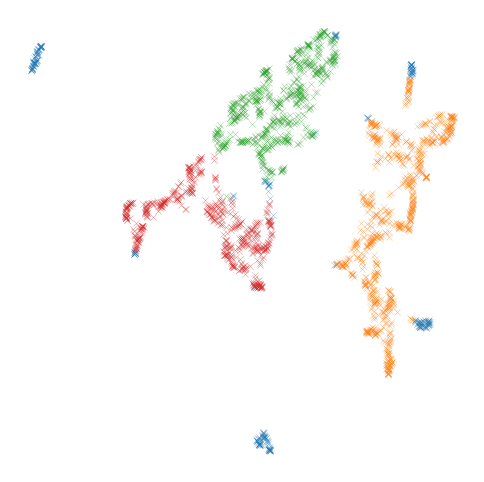

In [86]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i, iu in enumerate(u):
    ind = np.array(train_clusters) == iu
    # ind_val = np.array(test_clusters) == iu
    if sum(ind) > 200:
        col = f'C{i}'
        label = iu
    else:
        col = 'C0'
        label = -1
    # print(iu, sum(ind), sum(ind_val), label)

    # col = 'C0' if sum(ind)<200 and iu!=5 else f'C{i}'
    # label=f'{-1 if sum(ind)<200 and iu!=5 else iu}'
    # sns.scatterplot(x = scaled_test_features[ind_val, 0], y= scaled_test_features[ind_val, 1], c=col, ax=ax, marker='^', s=50, label=label)
    sns.scatterplot(x = scaled_train_features[ind, 0], y= scaled_train_features[ind, 1], c=col, ax=ax, marker='x', s=20, alpha=.5)

# sns.scatterplot(x = scaled_syn_features[:, 0], y= scaled_syn_features[:, 1], c=f'C{i}', ax=ax, marker='.', s=5)

# labels = ['gt_test', 'gt_train']
# labels += ['syn_train_clus6']
ax.axis('off')
# ax.legend()


plt.show()


### Visualize DBCV

<Axes: ylabel='$\\lambda$ value'>

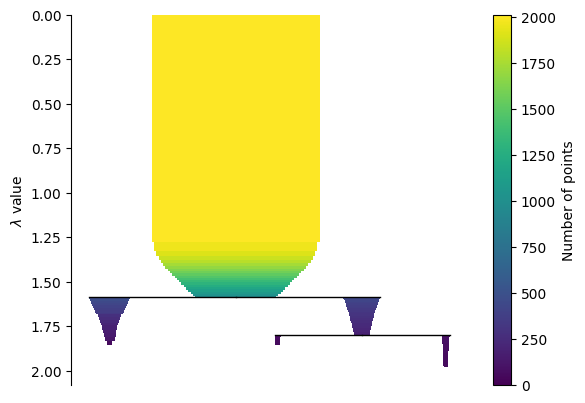

In [ ]:
best_model = exp_out["models"].iloc[0]
best_model.model.cluster_selection_epsilon

condensed_tree = best_model.model.condensed_tree_
condensed_tree.plot()

In [ ]:
tree = condensed_tree.to_numpy()
print(tree)

[(2013, 2014, 0.07991874, 1634) (2013, 2015, 0.07991874,  379)
 (2014, 2016, 0.0901928 , 1087) ... (2076, 1210, 6.03925528,    1)
 (2076,  868, 6.03925528,    1) (2076, 1978, 6.03925528,    1)]


<Axes: ylabel='distance'>

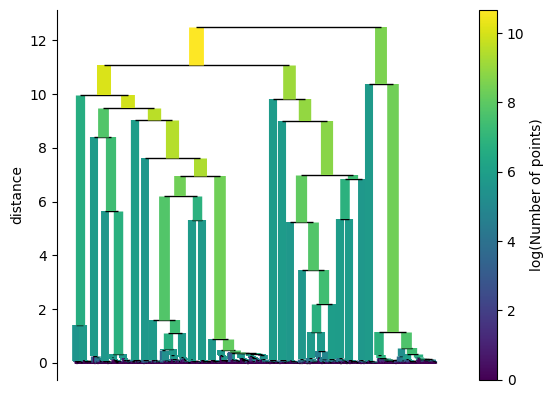

In [ ]:
single_linkage_tree = best_model.model.single_linkage_tree_

tree = single_linkage_tree.to_numpy()

tree[:, 0].max(), tree[:, 1].max()

single_linkage_tree.plot(cmap='viridis', colorbar=True)


(4023.0, 4022.0)

In [71]:

# par = exp_out["train_clusters"].iloc[0]

# for i, j, dist, size in tree.tolist():
#     i, j = int(i), int(j)
#     print(i, j, dist)
#     print(par[i], par[j], )
    


1146.0 1945.0 0.002572277898958791
2090550.3867423132


In [72]:
# import sklearn.datasets
# from dbcv import dbcv
# from sklearn.preprocessing import StandardScaler

# X, y = sklearn.datasets.make_moons(n_samples=300, noise=0.05, random_state=1782)
# y[0] = -1

# print(train_features.max(), train_features.min())
# print(X.max(), X.min())

# if False:
#     X = train_features
#     y = np.random.randint(-1, 3, len(train_features), dtype=np.int64)
#     X, scaled_val_features = reduce_features(train_features, val_features, EMB_TRANSFORM, emb_kwargs=emb_kwargs)

# print(X.shape, y.shape)
# # print(y)
# print(X.min(), X.max())
# print(y.min(), y.max())
# score = dbcv(X, y)
# print(score)


-1	0	1
258	1305	805
344	77	475


/root/miniconda3/envs/anomaly_detection/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


-1 64 0 -1
0 192 0 -1
1 192 0 -1
2 512 711 2
3 128 1 -1
4 448 23 4
5 192 97 5
6 256 57 6
7 192 4 -1
8 192 3 -1


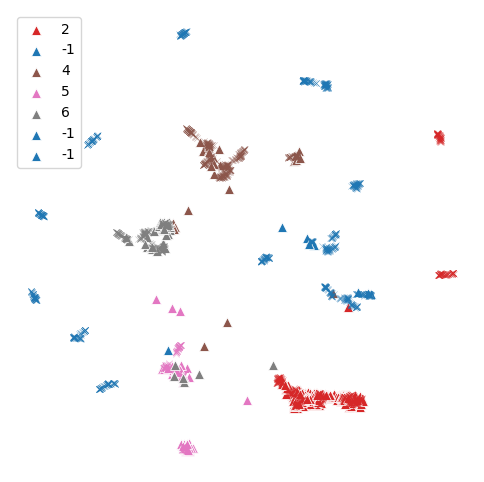

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i, iu in enumerate(u):
    ind = np.array(train_clusters) == iu
    ind_val = np.array(val_clusters) == iu
    if iu == 5 or sum(ind) > 200:
        col = f'C{i}'
        label = iu
    else:
        col = 'C0'
        label = -1
    print(iu, sum(ind), sum(ind_val), label)

    # col = 'C0' if sum(ind)<200 and iu!=5 else f'C{i}'
    # label=f'{-1 if sum(ind)<200 and iu!=5 else iu}'
    sns.scatterplot(x = scaled_val_features[ind_val, 0], y= scaled_val_features[ind_val, 1], c=col, ax=ax, marker='^', s=50, label=label)
    sns.scatterplot(x = scaled_train_features[ind, 0], y= scaled_train_features[ind, 1], c=col, ax=ax, marker='x', s=20, alpha=.5)

# sns.scatterplot(x = scaled_syn_features[:, 0], y= scaled_syn_features[:, 1], c=f'C{i}', ax=ax, marker='.', s=5)

# labels = ['gt_test', 'gt_train']
# labels += ['syn_train_clus6']
# ax.legend('')
ax.axis('off')
# ax.legend()


plt.show()
